# 1. 데이터 선정이유 및 문제 정의 
## 1-1. 데이터 선정이유
* 데이터 분야를 공부하는 많은 학습자들이 대중적으로 많이 접하는 데이터셋을 이용함으로써 다양한 관점을 비교할 수 있는 장점 보유.
* 샘플 수, 특성 수 등 현재 시점의 데이터 분석 실력에 적합함.
* 정석적인 관점으로 접근하면서 나만의 특성 공학을 발견하고자 함.

## 1-2. 문제 정의
* 소득이 50,000달러 이상인지 이하인지 예측하는 분류(Classification) 문제
* 타켓(Target): Income

*데이터 출처: Kaggle(US Adult Income / https://www.kaggle.com/johnolafenwa/us-census-data)

# 2. 가설 및 평가지표, 베이스라인 모델 선정
## 2-1. 가설 설정
* 교육수준이 높으면 연간 소득이 5만 달러 이상일 것이다.
* 나이가 어린 사람보다 많은 사람이 소득이 더 높을 것이다.
* 결혼한 사람이 하지 않은 사람보다 소득이 더 높을 것이다.

## 2-2. 평가지표
* 정확도: 해당 지표가 높을 수록 좋은 모델로 판단
* AUC score를 함께 산출하여 비교

## 2-3. 베이스라인 모델
* DecisionTree 사용

## 2-Q1. 해당 특성을 Target으로 지정한 이유를 설명하세요.
* OECD 국가 내 선진국 중 선진국이라 불리는 국가군의 평균 1인당 국민소득이 5만 달러이다.(2019년 기준 11개국)
* 때문에 소득이 5만 달러 이상/이하 여부를 판단하는 특성이 흥미로웠다.

## 2-Q2. 해당 베이스라인 모델과 평가지표를 선택한 이유를 설명하세요
* 베이스라인 모델인 DecisionTree는 가장 보편적으로 사용하는 지표로서 선택함.
* AUC score는 이진 분류기의 성능을 측정하는데 널리 사용됨

# 3. EDA와 데이터 전처리

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
import xgboost as xgb
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap

%matplotlib inline

In [ ]:
# 데이터셋 불러오기
df_train = pd.read_csv('/content/drive/MyDrive/2. Data Science/1. CodeStates/3. Project/Section2_Project/Dataset/adult-training.csv', header=None)
df_test = pd.read_csv('/content/drive/MyDrive/2. Data Science/1. CodeStates/3. Project/Section2_Project/Dataset/adult-test.csv', header=None)

columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Income']

df_train.columns = columns
df_test.columns = columns

In [ ]:
# 데이터셋 크기 확인
df_train.shape, df_test.shape

((32561, 15), (16281, 15))

In [ ]:
# 데이터셋 Preview
df_train.head()

,Age,Workclass,fnlgwt,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
df_test.head()

,Age,Workclass,fnlgwt,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


#### *데이터 Feature 설명
*   Age: 나이
*   Workclass: 고용형태
*   fnlgwt: 가중치(관측 결과에 따른 인구조사국이 부여)
*   Education: 최종 학력
*   Education Num: 교육 수준(숫자가 높을수록 교육 수준이 높음)
*   Marital Status: 결혼여부
*   Occupation: 직업
*   Relationship: 가정 내 위치(관계)
*   Race: 인종
*   Sex: 성별
*   Capital Gain: 자본 이익
*   Capital Loss: 자본 손실
*   Hours/Week: 주당 근무시간
*   Country: 출신 국가
*   Income: 연간 소득 50,000달러 이상/이하 여부



## 3-1. 타입별 분석
* 수치형 특성(6개): Age, fnlgwt, Education Num, Captial Gain, Capital Loss, Hours/Week
* 범주형 특성(9개): Workclass, Education, Marital Status, Occpation, Relationship, Race, Sex, Country, Income

In [ ]:
# Feature info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlgwt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education Num   32561 non-null  int64 
 5   Marital Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  Capital Loss    32561 non-null  int64 
 12  Hours/Week      32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## 3-2. 통계치 분석
* High Cadinality Feature(가장 많은 범주를 가지는 특성): 'Country'(41~42개)
* Capital Gain 특성에는 Max 값이 '99999'가 존재(이상치 인지, 실제값 or 계산 상 최대값 마지막 표현인지 확인 필요)

In [ ]:
# Feature 통계치
df_train.describe(include='all', percentiles=[.01, .25, .75, .99])

,Age,Workclass,fnlgwt,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Income
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
1%,17.000000,NaN,2.718580e+04,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,8.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN


In [ ]:
df_test.describe(include='all', percentiles=[.01, .25, .75, .99])

,Age,Workclass,fnlgwt,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Income
count,16281.000000,16281,1.628100e+04,16281,16281.000000,16281,16281,16281,16281,16281,16281.000000,16281.000000,16281.000000,16281,16281
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K.
freq,NaN,11210,NaN,5283,NaN,7403,2032,6523,13946,10860,NaN,NaN,NaN,14662,12435
mean,38.767459,NaN,1.894357e+05,NaN,10.072907,NaN,NaN,NaN,NaN,NaN,1081.905104,87.899269,40.392236,NaN,NaN
std,13.849187,NaN,1.057149e+05,NaN,2.567545,NaN,NaN,NaN,NaN,NaN,7583.935968,403.105286,12.479332,NaN,NaN
min,17.000000,NaN,1.349200e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
1%,17.000000,NaN,2.708580e+04,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,8.000000,NaN,NaN
25%,28.000000,NaN,1.167360e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.778310e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN


## 3-3. 결측치 확인
* 결측치 확인 결과 > "없음"

In [ ]:
df_train.isnull().sum()

Age               0
Workclass         0
fnlgwt            0
Education         0
Education Num     0
Marital Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital Gain      0
Capital Loss      0
Hours/Week        0
Country           0
Income            0
dtype: int64

## 3-4. 타켓(target) 분석
* 불균형 클래스 비율을 가지고 있음. 추후 모델 설정 시 class_weight 조정 필요
    * 5만 달러 이하: 75.9%
    * 5만 달러 초과: 24.1%



In [ ]:
# Target 분포
df_train['Income'].value_counts(normalize=True)

 <=50K    0.75919
 >50K     0.24081
Name: Income, dtype: float64

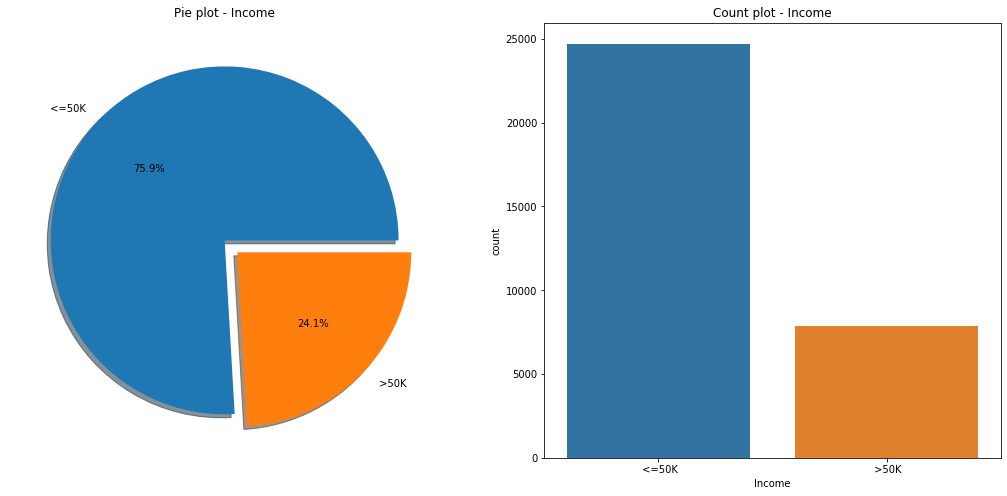

In [ ]:
# Target 분포 시각화
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train['Income'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Income')
ax[0].set_ylabel('')
sns.countplot('Income', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Income')
plt.show()

In [ ]:
# Target 변수 변환(0과 1)
df_train['Income'] = pd.get_dummies(df_train['Income'], drop_first=True, dtype=int)
df_test['Income'] = pd.get_dummies(df_test['Income'], drop_first=True, dtype=int)

In [ ]:
df_train.head()

,Age,Workclass,fnlgwt,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [ ]:
df_test.head()

,Age,Workclass,fnlgwt,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


In [ ]:
df_train.dtypes

Age                int64
Workclass         object
fnlgwt             int64
Education         object
Education Num      int64
Marital Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital Gain       int64
Capital Loss       int64
Hours/Week         int64
Country           object
Income             int64
dtype: object

## 3-5. 특성별 분석

###3-5-1. Age: 수치형 데이터
* 사회초년기라 할 수 있는 20대 전후가 소득이 5만 달러 이하가 가장 많다.
* 상대적으로 경험이 쌓이고 경제 활동이 활발한 30대 중후반 ~ 40대 중반까지가 소득 5만 달러 초과가 가장 많다.

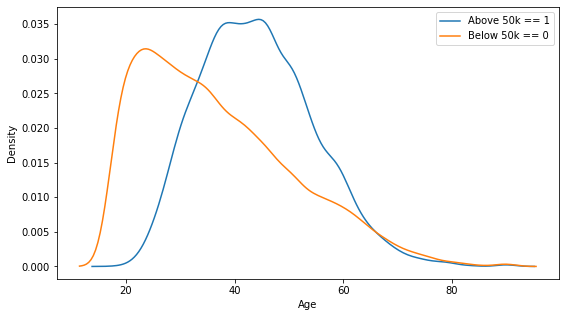

In [ ]:
# Age: 수치형 데이터
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['Income'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Income'] == 0]['Age'], ax=ax)
plt.legend(['Above 50k == 1', 'Below 50k == 0'])
plt.show()

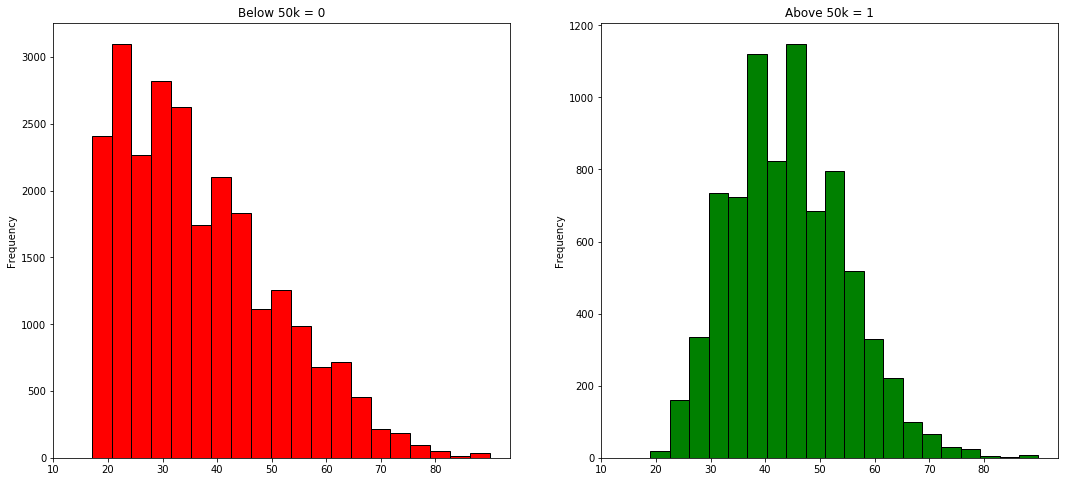

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[df_train['Income']==0].Age.plot.hist(ax=ax[0], bins=20, edgecolor='black', color='red')
ax[0].set_title('Below 50k = 0')
x1=list(range(10, 90, 10))
ax[0].set_xticks(x1)
df_train[df_train['Income']==1].Age.plot.hist(ax=ax[1], color='green', bins=20,edgecolor='black')
ax[1].set_title('Above 50k = 1')
x2=list(range(10,90,10))
ax[1].set_xticks(x2)
plt.show()

In [ ]:
# 특성 공학: Age를 그룹화하여 범위에 따른 숫자로 줄이기
def category_age(x):
    if x < 20:
        return 0
    if x < 30:
        return 1
    if x < 40:
        return 2
    if x < 50:
        return 3
    if x < 60:
        return 4
    if x < 70:
        return 5
    if x < 80:
        return 6
    else:
        return 7

df_train['Age'] = df_train['Age'].apply(category_age)
df_test['Age'] = df_test['Age'].apply(category_age)

In [ ]:
df_train['Age'].value_counts(sort=False)

0    1657
1    8054
2    8613
3    7175
4    4418
5    2015
6     508
7     121
Name: Age, dtype: int64

### 3-5-2. Workclass: 범주형 데이터
* 'Private' 클래스가 가장 많은 비율을 차지하고 있음.
* Numeric 타입으로 변환

In [ ]:
# Workclass: 범주형 데이터
df_train['Workclass'].value_counts(normalize=True)

 Private             0.697030
 Self-emp-not-inc    0.078038
 Local-gov           0.064279
 ?                   0.056386
 State-gov           0.039864
 Self-emp-inc        0.034274
 Federal-gov         0.029483
 Without-pay         0.000430
 Never-worked        0.000215
Name: Workclass, dtype: float64

In [ ]:
df_test['Workclass'].value_counts(normalize=True)

 Private             0.688533
 Self-emp-not-inc    0.081138
 Local-gov           0.064062
 ?                   0.059149
 State-gov           0.041951
 Self-emp-inc        0.035563
 Federal-gov         0.028991
 Without-pay         0.000430
 Never-worked        0.000184
Name: Workclass, dtype: float64

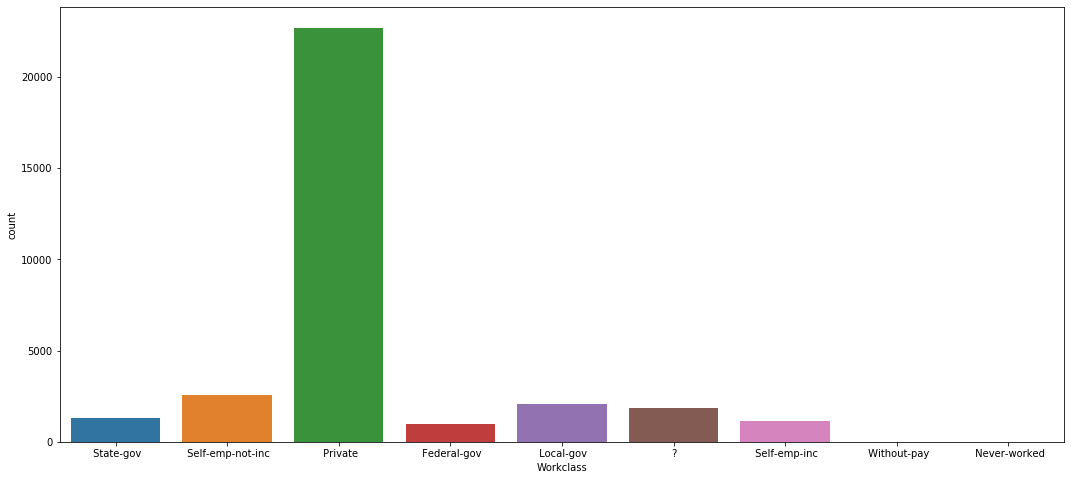

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot(df_train['Workclass'])

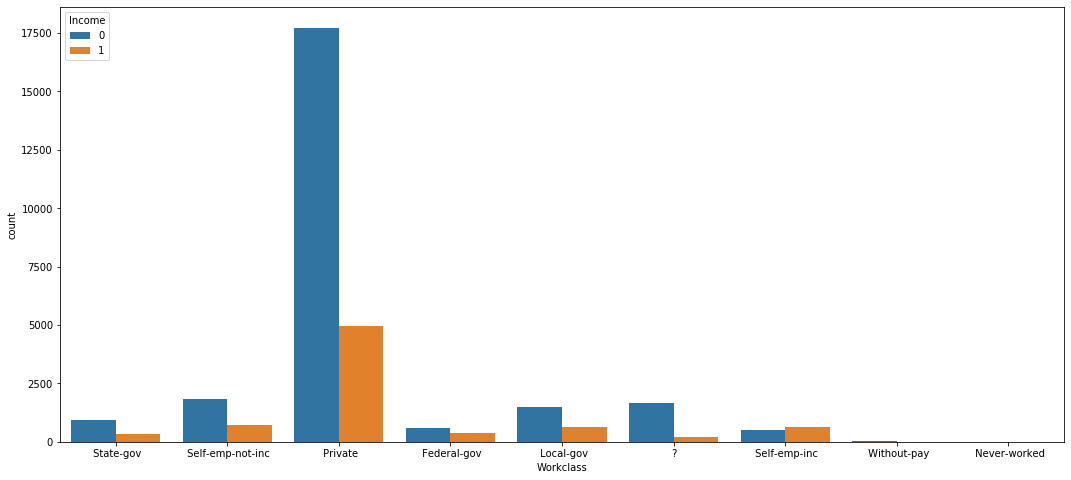

In [ ]:
# 직업형태에 따른 소득 분포
f,ax=plt.subplots(figsize=(18,8)) 
sns.countplot('Workclass',hue='Income',data=df_train)

In [ ]:
# Label Encoder 사용하기
le = LabelEncoder()
df_train['Workclass'] = le.fit_transform(df_train['Workclass'])
df_test['Workclass'] = le.fit_transform(df_test['Workclass'])

### 3-5-3. Education: 범주형 데이터
* Masters, Doctorate, Prof-School 클래스의 경우 소득 5만 달러 초과가 더 높은 수치를 보여준다.
* 'Education', 'Education Num'은 결국 같은 특성을 나타내기때문에 중복된다.
    * 파라미터의 수가 불필요하게 증가하여 차원의 저주에 빠질 우려가 있음으로 컬럼 제거

In [ ]:
df_train['Education'].value_counts(normalize=True)

 HS-grad         0.322502
 Some-college    0.223918
 Bachelors       0.164461
 Masters         0.052916
 Assoc-voc       0.042443
 11th            0.036086
 Assoc-acdm      0.032769
 10th            0.028654
 7th-8th         0.019840
 Prof-school     0.017690
 9th             0.015786
 12th            0.013298
 Doctorate       0.012684
 5th-6th         0.010227
 1st-4th         0.005160
 Preschool       0.001566
Name: Education, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

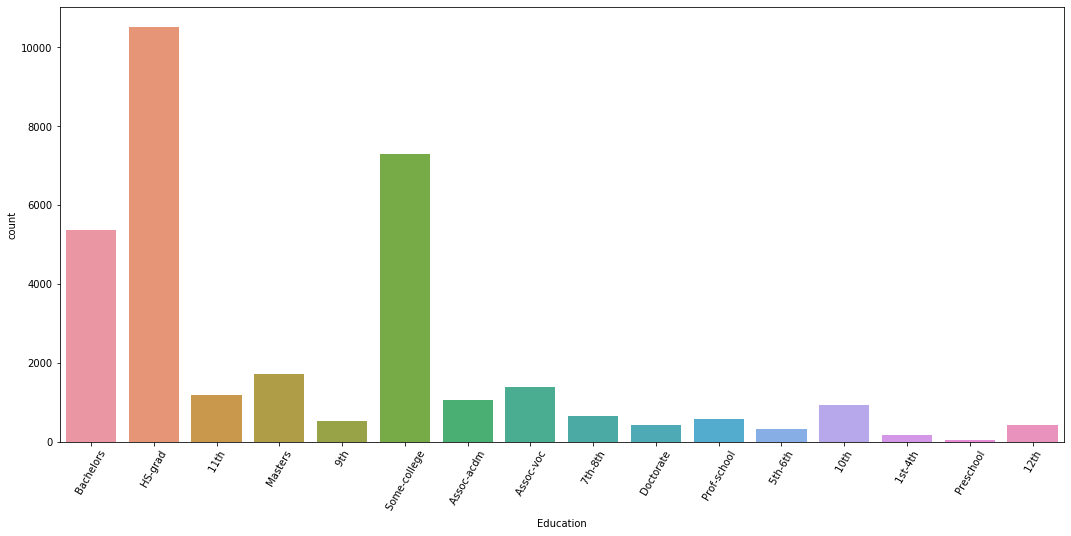

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot(df_train['Education'])
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

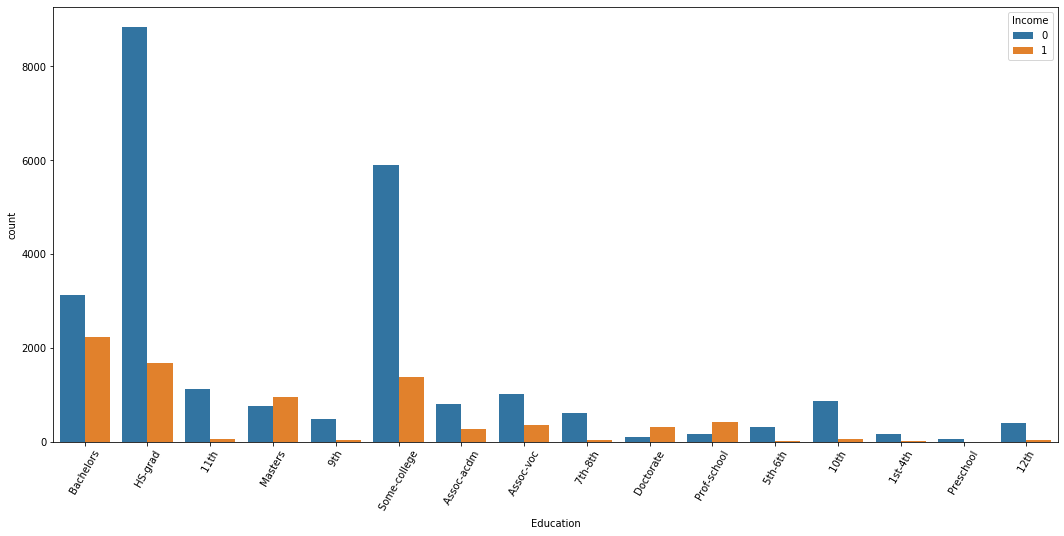

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot('Education', hue='Income', data=df_train)
plt.xticks(rotation=60)

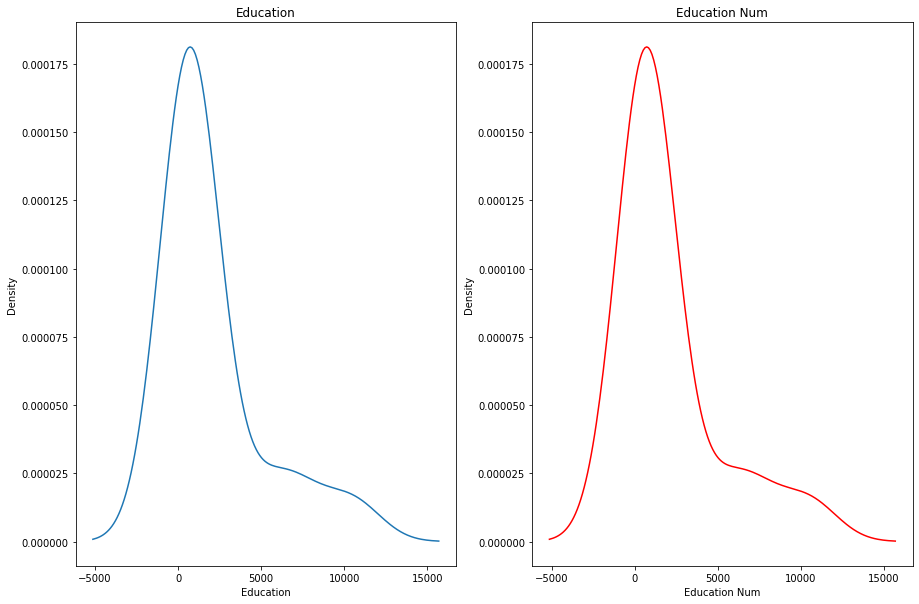

In [ ]:
# 'Eduacion'과 'Education Num' 관계 분석
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sns.kdeplot(df_train['Education'].value_counts(), ax=ax[0])
ax[0].set_title('Education')
sns.kdeplot(df_train['Education Num'].value_counts(), color='red', ax=ax[1])
ax[1].set_title('Education Num')
plt.show()

In [ ]:
# 'Education' 특성 제거(사유: 중복)
df_train.drop(columns='Education', axis=1, inplace=True)
df_test.drop(columns='Education', axis=1, inplace=True)

### 3-5-4. Marital Status: 범주형 데이터
* 특이사항 없음
* Numeric 타입으로 변환

In [ ]:
# Marital Status: 범주형 데이터
df_train['Marital Status'].value_counts(normalize=True)

 Married-civ-spouse       0.459937
 Never-married            0.328092
 Divorced                 0.136452
 Separated                0.031479
 Widowed                  0.030497
 Married-spouse-absent    0.012837
 Married-AF-spouse        0.000706
Name: Marital Status, dtype: float64

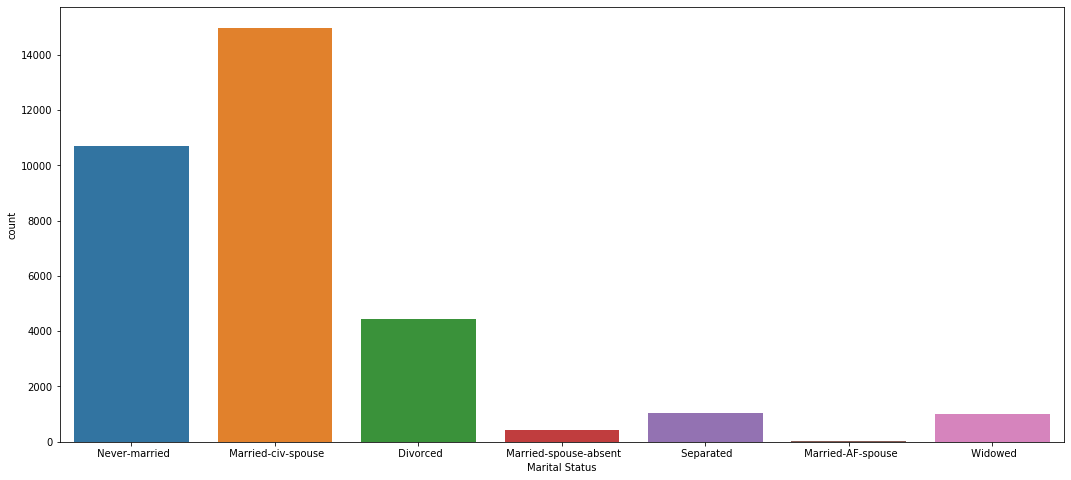

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot(df_train['Marital Status'])

In [ ]:
df_train.groupby(['Marital Status', 'Income'])['Income'].count()

Marital Status          Income
 Divorced               0          3980
                        1           463
 Married-AF-spouse      0            13
                        1            10
 Married-civ-spouse     0          8284
                        1          6692
 Married-spouse-absent  0           384
                        1            34
 Never-married          0         10192
                        1           491
 Separated              0           959
                        1            66
 Widowed                0           908
                        1            85
Name: Income, dtype: int64

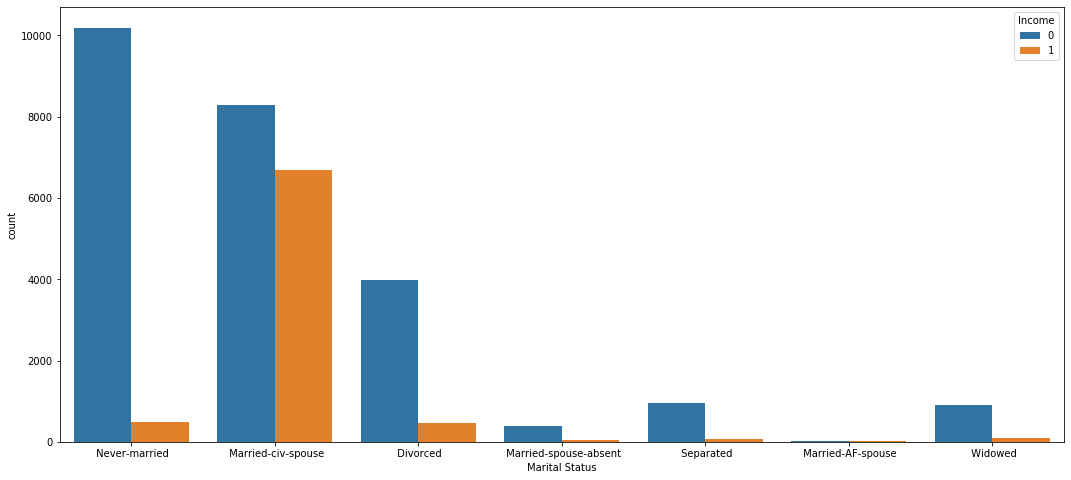

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot('Marital Status', hue='Income', data=df_train)

In [ ]:
# Label Encoder 사용하기
df_train['Marital Status'] = le.fit_transform(df_train['Marital Status'])
df_test['Marital Status'] = le.fit_transform(df_test['Marital Status'])

### 3-5-5. Occuapation: 범주형 데이터
* 'Workclass' 특성과 같은 '?' 클래스 존재(추후 처리)
* Numeric 타입으로 변환

In [ ]:
# Occuapation: 범주형 데이터
df_train['Occupation'].value_counts(normalize=True)

 Prof-specialty       0.127146
 Craft-repair         0.125887
 Exec-managerial      0.124873
 Adm-clerical         0.115783
 Sales                0.112097
 Other-service        0.101195
 Machine-op-inspct    0.061485
 ?                    0.056601
 Transport-moving     0.049046
 Handlers-cleaners    0.042075
 Farming-fishing      0.030527
 Tech-support         0.028500
 Protective-serv      0.019932
 Priv-house-serv      0.004576
 Armed-Forces         0.000276
Name: Occupation, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

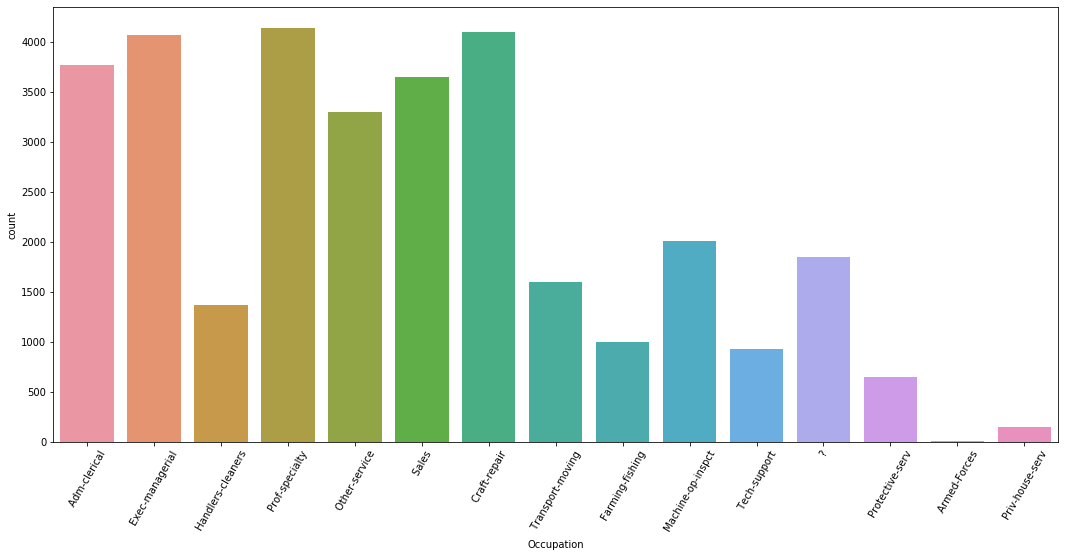

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot(df_train['Occupation'])
plt.xticks(rotation=60)

In [ ]:
df_train.groupby(['Occupation', 'Income'])['Income'].count()

Occupation          Income
 ?                  0         1652
                    1          191
 Adm-clerical       0         3263
                    1          507
 Armed-Forces       0            8
                    1            1
 Craft-repair       0         3170
                    1          929
 Exec-managerial    0         2098
                    1         1968
 Farming-fishing    0          879
                    1          115
 Handlers-cleaners  0         1284
                    1           86
 Machine-op-inspct  0         1752
                    1          250
 Other-service      0         3158
                    1          137
 Priv-house-serv    0          148
                    1            1
 Prof-specialty     0         2281
                    1         1859
 Protective-serv    0          438
                    1          211
 Sales              0         2667
                    1          983
 Tech-support       0          645
                    1       

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

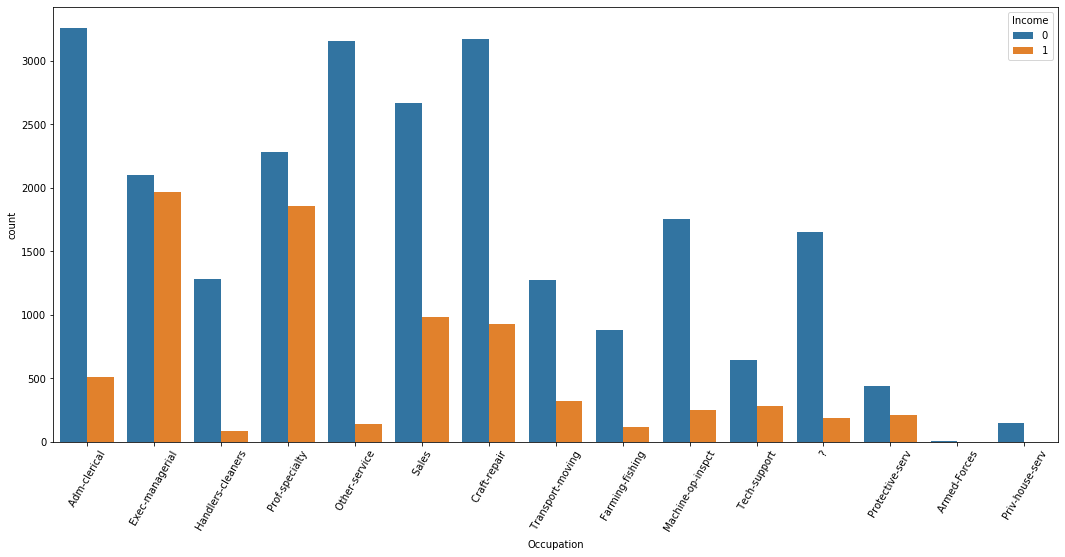

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot('Occupation', hue='Income', data=df_train)
plt.xticks(rotation=60)

In [ ]:
# Label Encoder 사용하기
df_train['Occupation'] = le.fit_transform(df_train['Occupation'])
df_test['Occupation'] = le.fit_transform(df_test['Occupation'])

### 3-5-6. Relationship: 범주형 데이터
* 소득이 5만 달러가 넘는 성인 중 대다수가 '남편' 역할을 가정에서 수행하고 있다.
* '부인'의 경우 전체 수는 적지만, 소득 기준을 나눴을 때 비슷한 경향을 보이고 있다.
* Numeric 타입으로 변환

In [ ]:
# Relationship: 범주형 데이터
df_train['Relationship'].value_counts(normalize=True)

 Husband           0.405178
 Not-in-family     0.255060
 Own-child         0.155646
 Unmarried         0.105832
 Wife              0.048156
 Other-relative    0.030128
Name: Relationship, dtype: float64

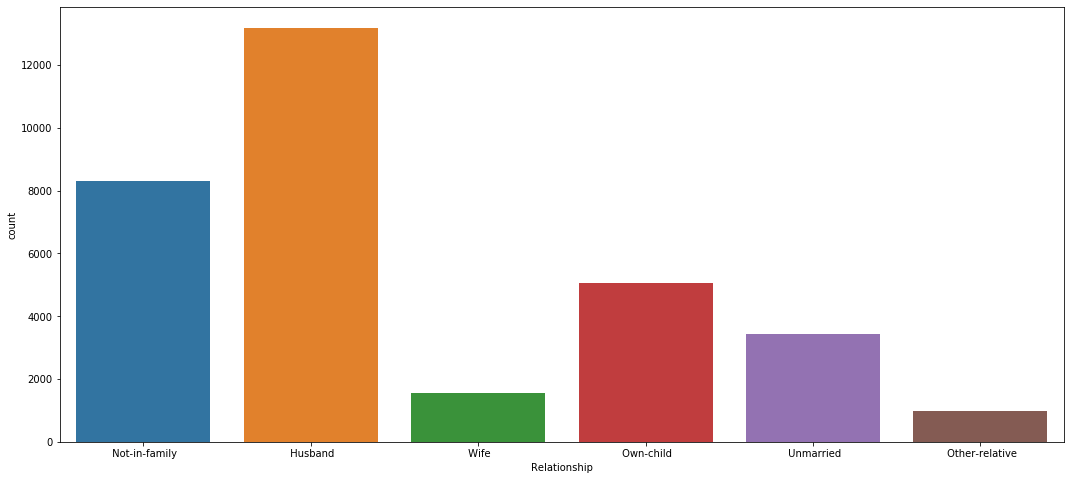

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot(df_train['Relationship'])

In [ ]:
df_train.groupby(['Relationship', 'Income'])['Income'].count()

Relationship     Income
 Husband         0         7275
                 1         5918
 Not-in-family   0         7449
                 1          856
 Other-relative  0          944
                 1           37
 Own-child       0         5001
                 1           67
 Unmarried       0         3228
                 1          218
 Wife            0          823
                 1          745
Name: Income, dtype: int64

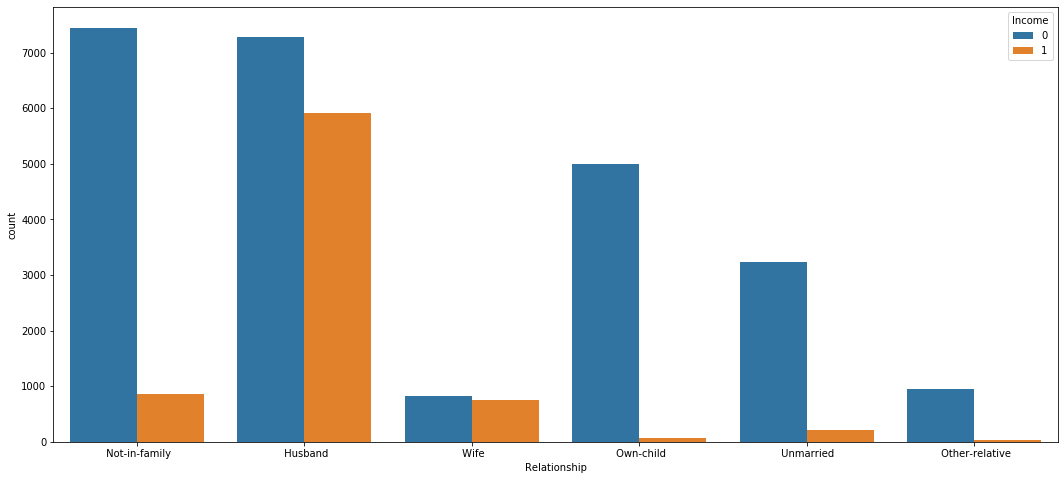

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot('Relationship', hue='Income', data=df_train)

In [ ]:
# Label Encoder 사용하기
df_train['Relationship'] = le.fit_transform(df_train['Relationship'])
df_test['Relationship'] = le.fit_transform(df_test['Relationship'])

### 3-5-7. Race: 범주형 데이터
* 'White' 클래스가 양쪽 소득 기준 모두 타 클래스에 비해 많다.
* Numeric 타입으로 변환

In [ ]:
df_train['Race'].value_counts(normalize=True)

 White                 0.854274
 Black                 0.095943
 Asian-Pac-Islander    0.031909
 Amer-Indian-Eskimo    0.009551
 Other                 0.008323
Name: Race, dtype: float64

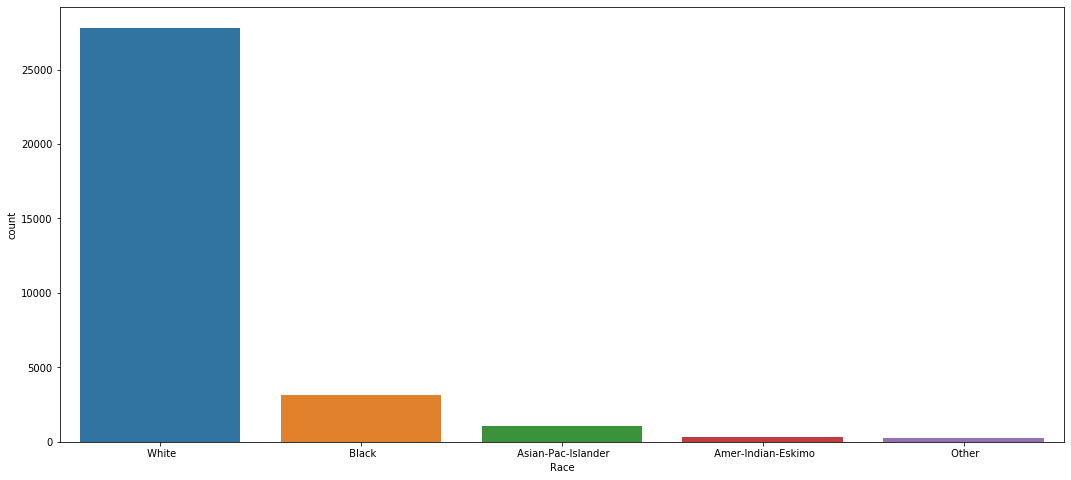

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot(df_train['Race'])

In [ ]:
df_train.groupby(['Race', 'Income'])['Income'].count()

Race                 Income
 Amer-Indian-Eskimo  0           275
                     1            36
 Asian-Pac-Islander  0           763
                     1           276
 Black               0          2737
                     1           387
 Other               0           246
                     1            25
 White               0         20699
                     1          7117
Name: Income, dtype: int64

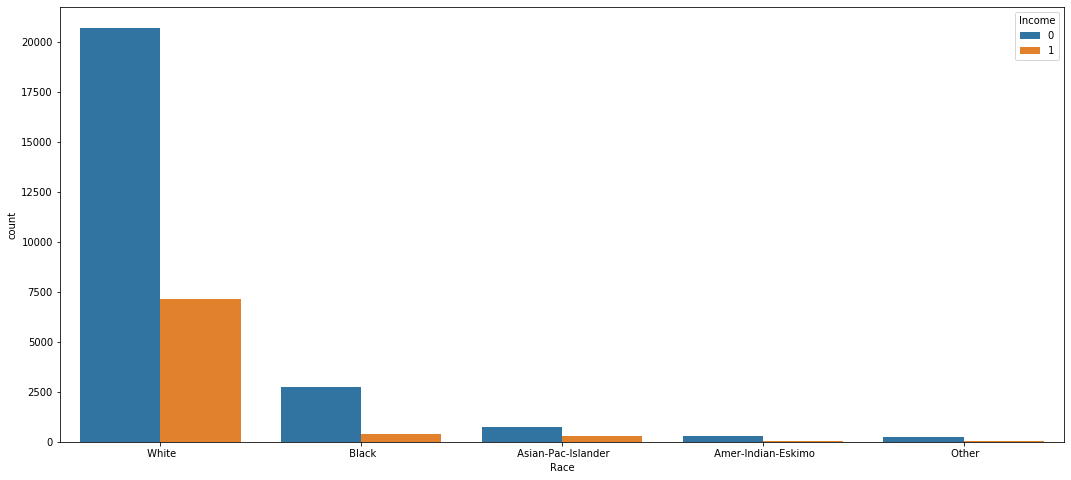

In [ ]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot('Race', hue='Income', data=df_train)

In [ ]:
# Label Encoder 사용하기
df_train['Race'] = le.fit_transform(df_train['Race'])
df_test['Race'] = le.fit_transform(df_test['Race'])

### 3-5-8. Sex: 범주형 데이터
* 남자가 여자에 비해 5만 달러 초과 수가 압도적으로 많다.
* Numeric 타입으로 변환

In [ ]:
# 성별에 따른 Income 분포
df_train.groupby(['Sex', 'Income'])['Income'].count()

Sex      Income
 Female  0          9592
         1          1179
 Male    0         15128
         1          6662
Name: Income, dtype: int64

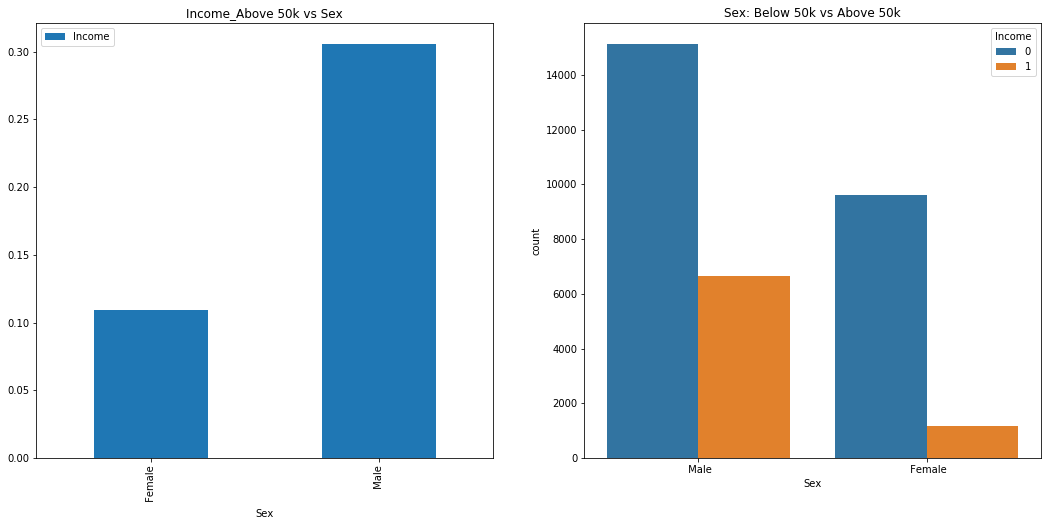

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df_train[['Sex','Income']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Income_Above 50k vs Sex')
sns.countplot('Sex',hue='Income',data=df_train,ax=ax[1])
ax[1].set_title('Sex: Below 50k vs Above 50k')
plt.show()

In [ ]:
# Label Encoder 사용하기
df_train['Sex'] = le.fit_transform(df_train['Sex'])
df_test['Sex'] = le.fit_transform(df_test['Sex'])

### 3-5-9. Capital Gain/Loss: 수치형 데이터
* 특성 공학 적용: 2개 특성을 합쳐 새로운 'Capital' 특성 생성(Gain - Loss)
* 치우진 분포를 조정하기 위해 Log를 취함 > 아주 약간의 변화만 있음

In [ ]:
df_train[['Capital Gain', 'Capital Loss']].describe()

,Capital Gain,Capital Loss
count,32561.000000,32561.000000
mean,1077.648844,87.303830
std,7385.292085,402.960219
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,99999.000000,4356.000000


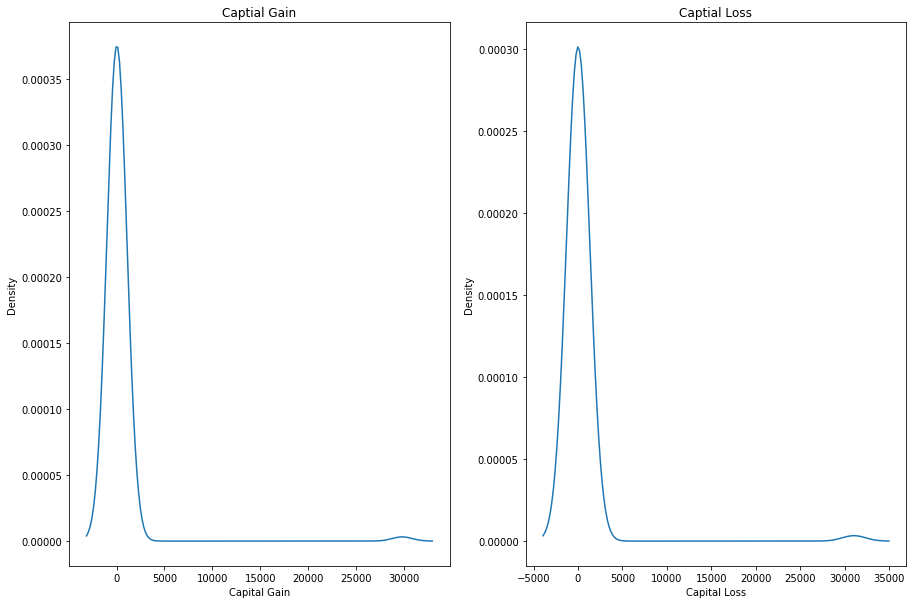

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sns.kdeplot(df_train['Capital Gain'].value_counts(), ax=ax[0])
ax[0].set_title('Captial Gain')
sns.kdeplot(df_train['Capital Loss'].value_counts(), ax=ax[1])
ax[1].set_title('Captial Loss')
plt.show()

In [ ]:
# 특성 공학: 2개 특성 합쳐 1개 특성으로 만들기(Gain - Loss)
df_train['Capital'] = df_train['Capital Gain'] - df_train['Capital Loss']
df_train.drop(columns=['Capital Gain', 'Capital Loss'], axis=1, inplace=True)
df_test['Capital'] = df_test['Capital Gain'] - df_test['Capital Loss']
df_test.drop(columns=['Capital Gain', 'Capital Loss'], axis=1, inplace=True)

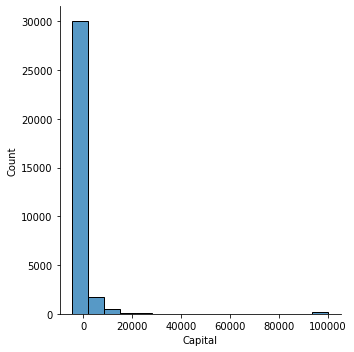

In [ ]:
sns.displot(df_train['Capital'])

In [ ]:
# 여전히 치우친 분포를 보이기때문에 log를 취해주어 조금 더 정규성을 띄게 만드는 작업 진행
df_train['Capital'] = df_train['Capital'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Capital'] = df_test['Capital'].map(lambda i: np.log(i) if i > 0 else 0)

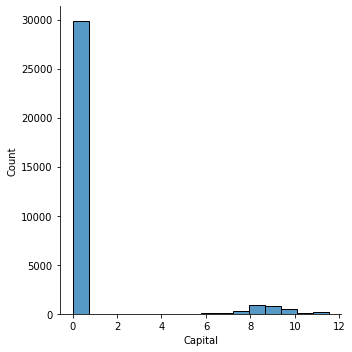

In [ ]:
sns.displot(df_train['Capital'])

### 3-5-10. Hours/Week: 수치형 데이터
* 주당 평균 근무시간 약 40시간으로 40시간 전후가 가장 많은 분포를 차지하고 있다.
* 5만 달러 기준으로 각 클래스에서 35~40시간 근무하는 비중이 가장 높다.

In [ ]:
df_train['Hours/Week'].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Hours/Week, dtype: float64

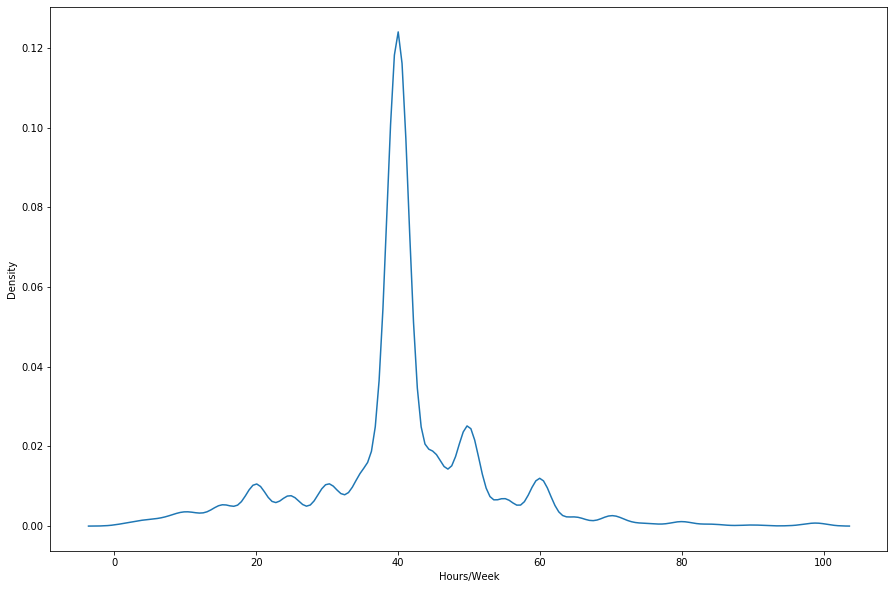

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.kdeplot(df_train['Hours/Week'])

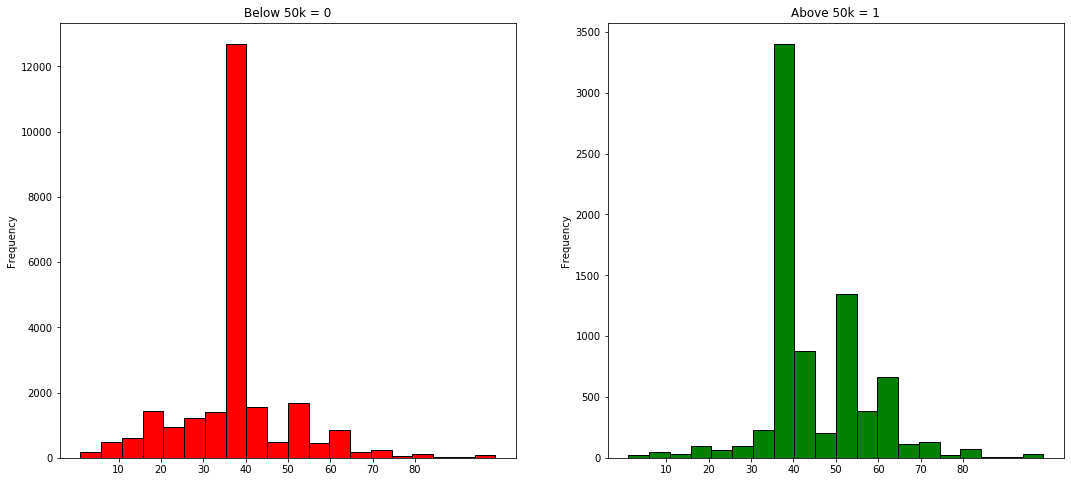

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[df_train['Income']==0]['Hours/Week'].plot.hist(ax=ax[0], bins=20, edgecolor='black', color='red')
ax[0].set_title('Below 50k = 0')
x1=list(range(10, 90, 10))
ax[0].set_xticks(x1)
df_train[df_train['Income']==1]['Hours/Week'].plot.hist(ax=ax[1], color='green', bins=20,edgecolor='black')
ax[1].set_title('Above 50k = 1')
x2=list(range(10,90,10))
ax[1].set_xticks(x2)
plt.show()

### 3-5-11. Country: 범주형 데이터
* high cadinality를 가진 특성으로, 추후 Feature Importance에 따라 drop하거나 encoding 필요

In [ ]:
df_train['Country'].value_counts(normalize=True)

 United-States                 0.895857
 Mexico                        0.019748
 ?                             0.017905
 Philippines                   0.006081
 Germany                       0.004207
 Canada                        0.003716
 Puerto-Rico                   0.003501
 El-Salvador                   0.003255
 India                         0.003071
 Cuba                          0.002918
 England                       0.002764
 Jamaica                       0.002488
 South                         0.002457
 China                         0.002303
 Italy                         0.002242
 Dominican-Republic            0.002150
 Vietnam                       0.002058
 Guatemala                     0.001966
 Japan                         0.001904
 Poland                        0.001843
 Columbia                      0.001812
 Taiwan                        0.001566
 Haiti                         0.001351
 Iran                          0.001321
 Portugal                      0.001136


In [ ]:
df_train['Country'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

In [ ]:
# Label Encoder 사용하기
df_train['Country'] = le.fit_transform(df_train['Country'])
df_test['Country'] = le.fit_transform(df_test['Country'])

### 3-6. 특성별 상관관계
* Income과 상대적으로 양의 상관관계를 가지는 특성
    * Age, Education Num, Sex, Hours/Week, Capital
* Income과 상대적으로 음의 상관관계를 가지는 특성
    * Marital Status, Relationship

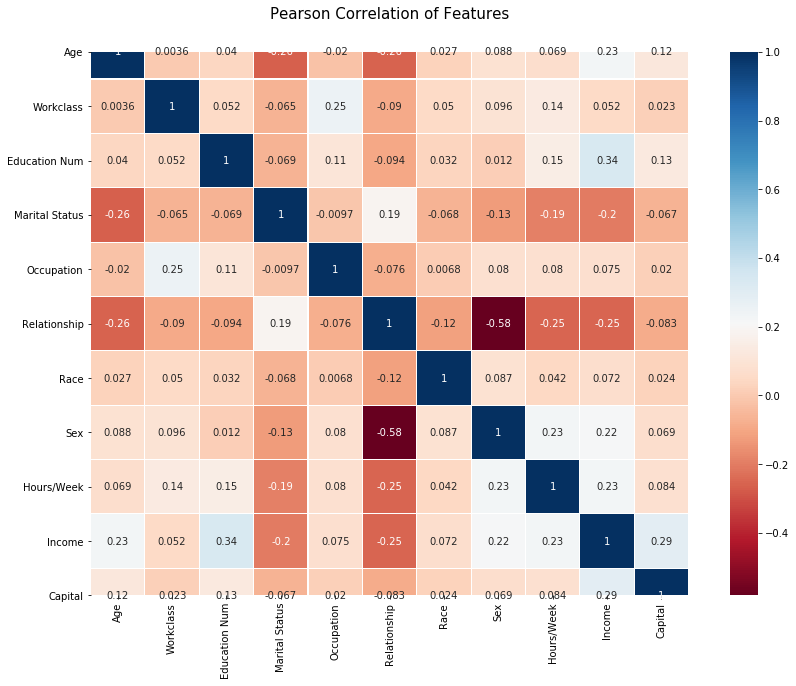

In [133]:
heatmap_data = df_train

colormap = plt.cm.RdBu
plt.figure(figsize=(15, 10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 10})

del heatmap_data

## 3-7. 필요없는 특성 버리기
* Income 예측과 큰 연관이 없는 특성 Drop

In [ ]:
drop_col = ['fnlgwt', 'Country']
df_train.drop(drop_col, axis=1, inplace=True)
df_test.drop(drop_col, axis=1, inplace=True)

## 3-8. 베이스라인 모델
* DecisionTreeClassifier 사용
* 정확도, AUC_Score, ROC_Curve 측정

In [ ]:
# target, features 변수 지정
target = 'Income'
features = df_train.drop([target], axis=1).columns

# train, val 분리
train, val = train_test_split(df_train, train_size=0.8, test_size=0.2, random_state=1004)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = df_test[features]
y_test = df_test[target]

In [ ]:
# DecisionTree 학습
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print('훈련 정확도:', dt.score(X_train, y_train))
print('검증 정확도:', dt.score(X_val, y_val))

훈련 정확도: 0.941492628992629
검증 정확도: 0.8129894058037771


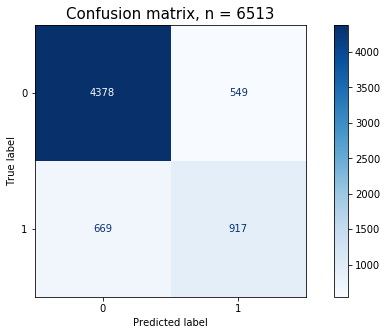

In [ ]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(10, 5))
pcm = plot_confusion_matrix(dt, X_val, y_val,
                            cmap=plt.cm.Blues, values_format='',
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [ ]:
# 결과지표
y_pred = dt.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4927
           1       0.63      0.58      0.60      1586

    accuracy                           0.81      6513
   macro avg       0.75      0.73      0.74      6513
weighted avg       0.81      0.81      0.81      6513



In [ ]:
# AUC_score 측정
y_pred_proba = dt.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

AUC score:  0.7902776501614619


Text(0, 0.5, 'TPR')

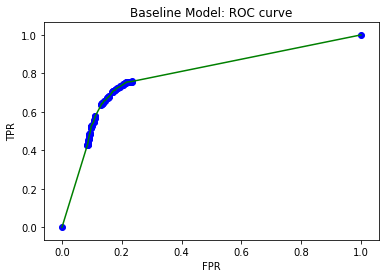

In [ ]:
# ROC_curve 그리기
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('Baseline Model: ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

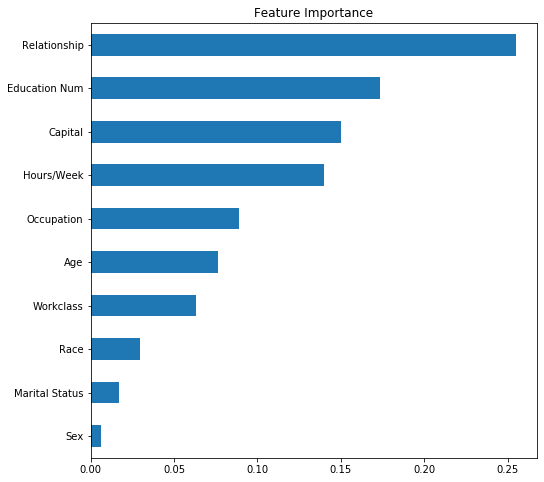

In [ ]:
# Feature Importance
importances = pd.Series(dt.feature_importances_, X_val.columns)
plt.figure(figsize=(8,8))
plt.title('Feature Importance')
importances.sort_values().plot.barh();

## 3-Q1. Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?
* train, val, test 셋 나누어 모델 학습 진행

## 3-Q2. 오상훈님이 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?
* 두 가지 범주(이진)를 분류하는데 유용함
* 회귀 문제, 다중 범주를 예측하는데 한계가 있음

# 4. 머신러닝 방식 적용 및 교차검증

## 4-1. 모델 학습 및 하이퍼파라미터 튜닝

In [ ]:
# RandomForest 모델 적용
model = RandomForestClassifier(random_state = 1004)  
model.fit(X_train, y_train)
predicted = model.predict(X_val)
y_model_proba = model.predict_proba(X_val)[:, -1]
print('훈련 정확도:', model.score(X_train, y_train))
print('검증 정확도:', model.score(X_val, y_val))
print('AUC score:', roc_auc_score(y_val, y_model_proba))
print('CV score:', cross_val_score(model, X_train, y_train, cv=3))

훈련 정확도: 0.941492628992629
검증 정확도: 0.8404729003531399
AUC score: 0.8868066456263977
CV score: [0.84475412 0.84843948 0.84231744]


In [ ]:
# 하이퍼파라미터 튜닝
dists = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [4, 6, 8, 10, None],
    'max_features': ['auto', 'sqrt']
}

clf = GridSearchCV(
    model,
    param_grid=dists,
    cv=5,
    n_jobs=-1
)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
pipe = clf.best_estimator_
y_h_pred = pipe.predict(X_val)
print('훈련 정확도:', pipe.score(X_train, y_train))
print('검증 정확도:', pipe.score(X_val, y_val))
print('AUC score:', roc_auc_score(y_val, y_h_pred))
print('CV score:', cross_val_score(pipe, X_train, y_train, cv=3))

훈련 정확도: 0.8680512899262899
검증 정확도: 0.8506064793489944
AUC score: 0.7462701341221173
CV score: [0.85684671 0.85327652 0.8503801 ]


Text(0, 0.5, 'TPR')

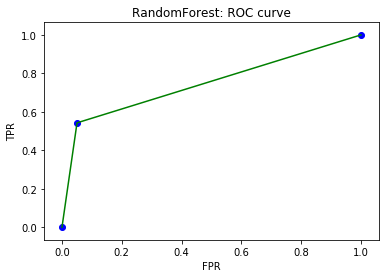

In [ ]:
# ROC_curve 그리기
fpr, tpr, thresholds = roc_curve(y_val, y_h_pred)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('RandomForest: ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
# XGBoostClassifier 모델 적용
model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)
predicted = model.predict(X_val)
y_model_proba = model.predict_proba(X_val)[:, -1]
print('훈련 정확도:', model.score(X_train, y_train))
print('검증 정확도:', model.score(X_val, y_val))
print('AUC score:', roc_auc_score(y_val, y_model_proba))
print('CV score:', cross_val_score(model, X_train, y_train, cv=3))

훈련 정확도: 0.8601428132678133
검증 정확도: 0.8552126516198373
AUC score: 0.9118617310846813
CV score: [0.8590349  0.85454336 0.85590878]


In [ ]:
# 하이퍼파라미터 튜닝
dists = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [4, 6, 8, 10, None],
    'max_features': ['auto', 'sqrt']
}

clf = GridSearchCV(
    model,
    param_grid=dists,
    cv=5,
    n_jobs=-1
)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, use_label_encoder=False,
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 10, None],
                         'max_features': ['auto', 'sqrt'],

In [ ]:
pipe = clf.best_estimator_
y_h_pred = pipe.predict(X_val)
print('훈련 정확도:', pipe.score(X_train, y_train))
print('검증 정확도:', pipe.score(X_val, y_val))
print('AUC score:', roc_auc_score(y_val, y_h_pred))
print('CV score:', cross_val_score(pipe, X_train, y_train, cv=3))

훈련 정확도: 0.8807202088452089
검증 정확도: 0.8636573007830493
AUC score: 0.7910243655734377
CV score: [0.8643326  0.86041691 0.86328035]


Text(0, 0.5, 'TPR')

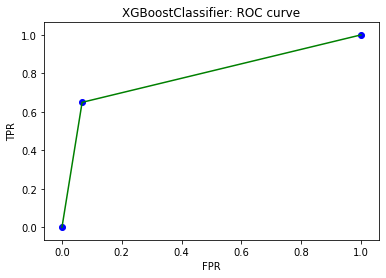

In [ ]:
# ROC_curve 그리기
fpr, tpr, thresholds = roc_curve(y_val, y_h_pred)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('XGBoostClassifier: ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
# KNeighborsClassifier 모델 적용
model = KNeighborsClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_val)
y_model_proba = model.predict_proba(X_val)[:, -1]
print('훈련 정확도:', model.score(X_train, y_train))
print('검증 정확도:', model.score(X_val, y_val))
print('AUC score:', roc_auc_score(y_val, y_model_proba))
print('CV score:', cross_val_score(model, X_train, y_train, cv=3))

훈련 정확도: 0.8693181818181818
검증 정확도: 0.8106863196683556
AUC score: 0.8365021495422065
CV score: [0.82667281 0.82586664 0.82342778]


In [ ]:
# 하이퍼파라미터 튜닝
dists = {
    'n_neighbors': randint(3, 20),
    'leaf_size': randint(20, 100),
    'weights': ['uniform', 'distance']
}

clf = RandomizedSearchCV(
    model,
    param_distributions=dists,
    n_iter=20,
    cv=3,
    n_jobs=-1
)

clf.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=20, n_jobs=-1,
                   param_distributions={'leaf_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa83c995d50>,
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa83c9dca90>,
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
pipe = clf.best_estimator_
y_h_pred = pipe.predict(X_val)
print('훈련 정확도:', pipe.score(X_train, y_train))
print('검증 정확도:', pipe.score(X_val, y_val))
print('AUC score:', roc_auc_score(y_val, y_h_pred))
print('CV score:', cross_val_score(pipe, X_train, y_train, cv=3))

훈련 정확도: 0.8566108722358723
검증 정확도: 0.8248119146322739
AUC score: 0.7262283436534052
CV score: [0.83289186 0.83300703 0.83229671]


Text(0, 0.5, 'TPR')

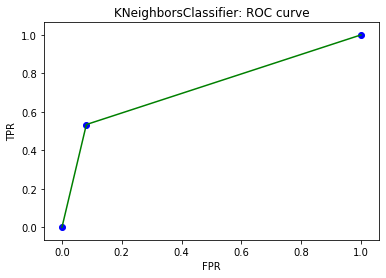

In [ ]:
# ROC_curve 그리기
fpr, tpr, thresholds = roc_curve(y_val, y_h_pred)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('KNeighborsClassifier: ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
# GradientBoostingClassifier 모델 적용
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_val)
y_model_proba = model.predict_proba(X_val)[:, -1]
print('훈련 정확도:', model.score(X_train, y_train))
print('검증 정확도:', model.score(X_val, y_val))
print('AUC score:', roc_auc_score(y_val, y_model_proba))
print('CV score:', cross_val_score(model, X_train, y_train, cv=3))

훈련 정확도: 0.8626382063882064
검증 정확도: 0.857362198679564
AUC score: 0.9128161447166461
CV score: [0.86076241 0.85373719 0.85625432]


In [ ]:
# 하이퍼파라미터 튜닝
dists = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0, 1),
    'max_depth': [3, 5, 7, 9],
    'max_features': uniform(0, 1)
}

clf = RandomizedSearchCV(
    model,
    param_distributions=dists,
    n_iter=30,
    cv=5,
    n_jobs=-1
)

clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [ ]:
pipe = clf.best_estimator_
y_h_pred = pipe.predict(X_val)
print('훈련 정확도:', pipe.score(X_train, y_train))
print('검증 정확도:', pipe.score(X_val, y_val))
print('AUC score:', roc_auc_score(y_val, y_h_pred))
print('CV score:', cross_val_score(pipe, X_train, y_train, cv=3))

훈련 정확도: 0.8771114864864865
검증 정확도: 0.861200675571933
AUC score: 0.7851251218611399
CV score: [0.8643326  0.8590349  0.86074637]


Text(0, 0.5, 'TPR')

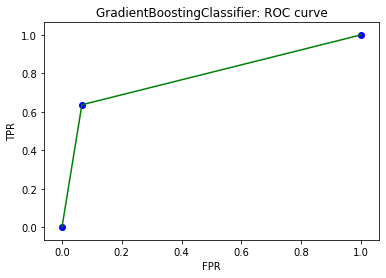

In [ ]:
# ROC_curve 그리기
fpr, tpr, thresholds = roc_curve(y_val, y_h_pred)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('GradientBoostingClassifier: ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

## 4-2. 최종 모델 선정
* GradientBoostingClassifier(Default 파라미터 사용)
    * 선정이유: 학습한 모델 중 train, val 정확도 차이가 적으며, AUC 스코어가 가장 높음

In [ ]:
# GradientBoostingClassifier 모델 학습
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_val)
y_model_proba = model.predict_proba(X_val)[:, -1]
print('훈련 정확도:', model.score(X_train, y_train))
print('검증 정확도:', model.score(X_val, y_val))
print('AUC score:', roc_auc_score(y_val, y_model_proba))
print('CV score:', cross_val_score(model, X_train, y_train, cv=3))

훈련 정확도: 0.8626382063882064
검증 정확도: 0.857362198679564
AUC score: 0.9128161447166461
CV score: [0.86076241 0.85385236 0.85625432]


In [ ]:
# Test 데이터 스코어
test_pre = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, -1]
print('Test 정확도:', model.score(X_test, y_test))
print('AUC score:', roc_auc_score(y_test, y_test_proba))
print('CV score:', cross_val_score(model, X_test, y_test, cv=3))

Test 정확도: 0.8608807812787912
AUC score: 0.913185851921411
CV score: [0.85166759 0.85848535 0.86253916]


In [ ]:
# GradientBoostingClassifier 모델 학습(하이퍼파라미터 튜닝: learning_rate=0.2)
model = GradientBoostingClassifier(learning_rate=0.2, max_depth=3, random_state=0)
model.fit(X_train, y_train)
predicted = model.predict(X_val)
y_model_proba = model.predict_proba(X_val)[:, -1]
print('훈련 정확도:', model.score(X_train, y_train))
print('검증 정확도:', model.score(X_val, y_val))
print('AUC score:', roc_auc_score(y_val, y_model_proba))
print('CV score:', cross_val_score(model, X_train, y_train, cv=3))

훈련 정확도: 0.8679361179361179
검증 정확도: 0.861200675571933
AUC score: 0.9151049842197982
CV score: [0.86606012 0.85776805 0.86097673]


In [ ]:
# Test 데이터 스코어
test_pre = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, -1]
print('Test 정확도:', model.score(X_test, y_test))
print('AUC score:', roc_auc_score(y_test, y_test_proba))
print('CV score:', cross_val_score(model, X_test, y_test, cv=3))

Test 정확도: 0.8617406793194521
AUC score: 0.915602934531535
CV score: [0.85443155 0.86401327 0.86364474]


## 4-Q1. 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?
* GradientBoostingClassifier 모델 학습 후 베이스라인과 비교시 더 나은 성능을 보여주었다.
## 4-Q2. 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?
* 모델의 성능을 개선하기 위해 하이퍼파라미터 튜닝을 시도했고, learning_rate를 조정하여 최적의 값을 찾았다.
* learning_rate는 오차를 보정하는 비율로, 기존 0.1에서 0.2로 시도한결과 가장 좋은 성능을 보여주었다.
## 4-Q3. 최종 모델에 관해 설명하세요.
* GradientBoostingClassifier 모델은 여러 개의 결정 트리를 묶어 부스팅하는 앙상블 기법으로 이전 트리의 오차를 보완하여 순차적으로 트리를 만든다.
* 각각의 트리는 데이터의 일부에 대해서만 맞춰져있어 트리가 많이 추가될수록 성능이 좋아진다.


# 5. 머신러닝 모델 해석

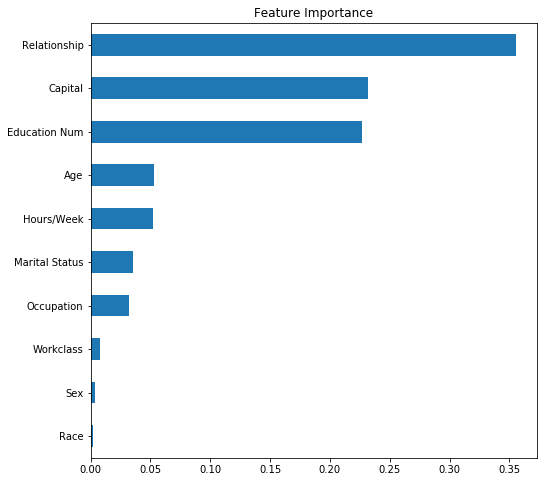

In [ ]:
# Feature Importance
importances = pd.Series(model.feature_importances_, X_test.columns)
plt.figure(figsize=(8,8))
plt.title('Feature Importance')
importances.sort_values().plot.barh();

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


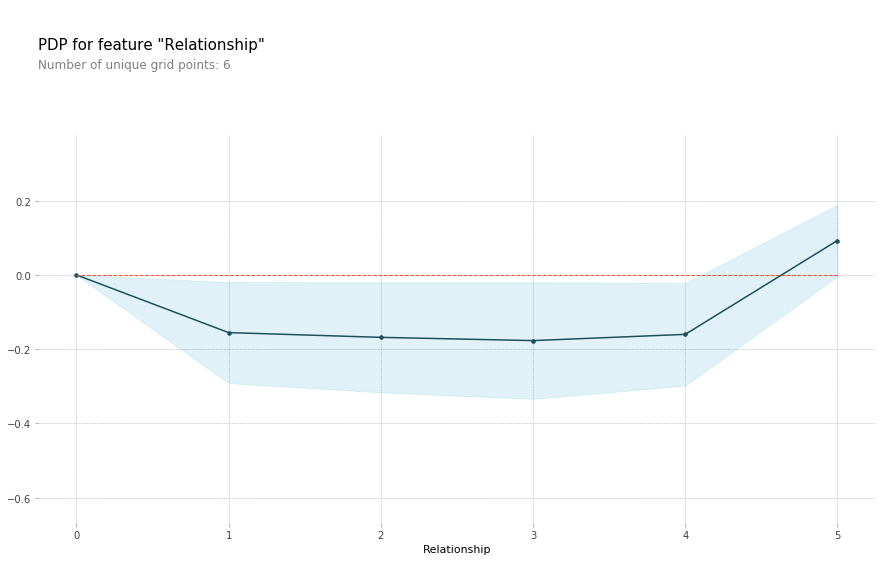

In [ ]:
#Partial Dependence Plots(PDP) - Relationship
feature = 'Relationship'
isolated = pdp_isolate(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature)
pdp_plot(isolated, feature_name=feature);

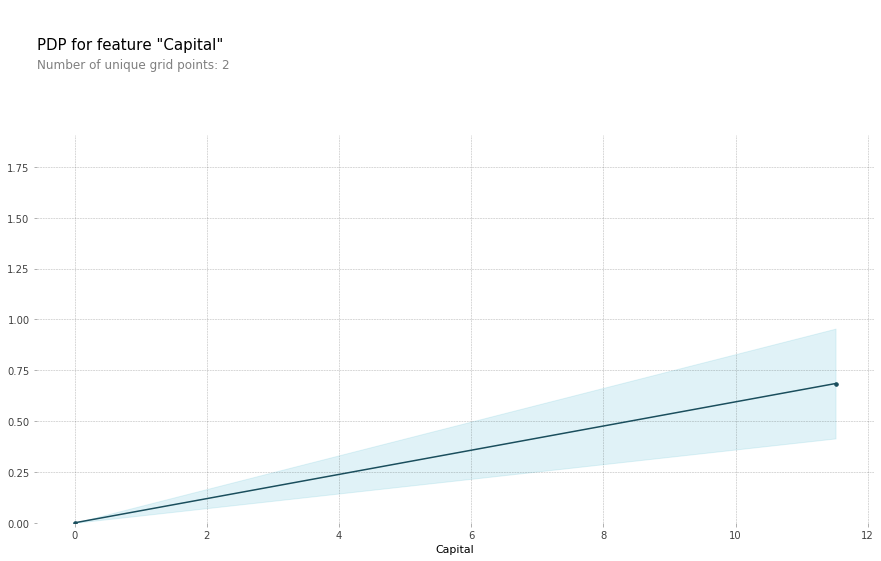

In [ ]:
#Partial Dependence Plots(PDP) - Capital
feature = 'Capital'
isolated = pdp_isolate(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature)
pdp_plot(isolated, feature_name=feature);

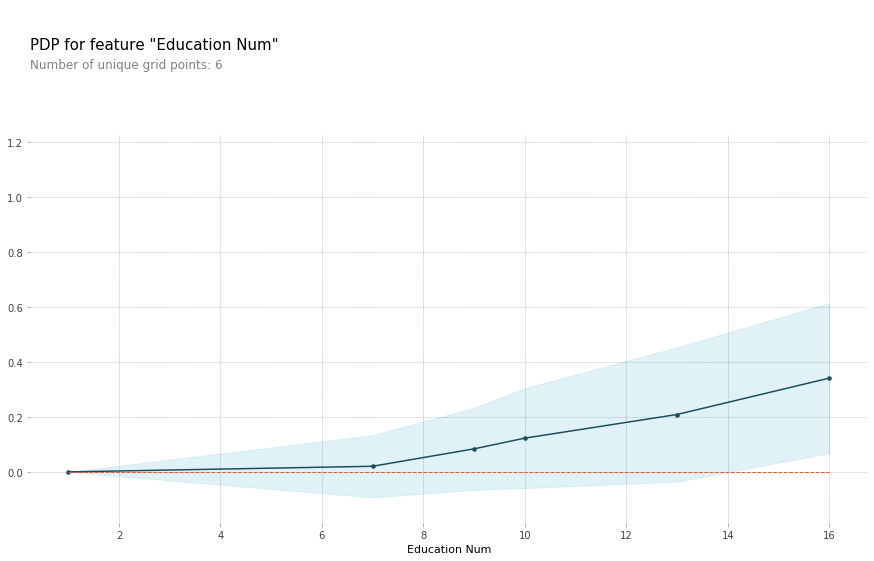

In [ ]:
#Partial Dependence Plots(PDP) - Education Num
feature = 'Education Num'
isolated = pdp_isolate(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature)

pdp_plot(isolated, feature_name=feature);

In [ ]:
# Shapley values: 5만 달러 초과 예측치
row = X_test.iloc[[7]]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
# Shapley values: 5만 달러 이하 예측치
row = X_test.iloc[[4]]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_test.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:100])

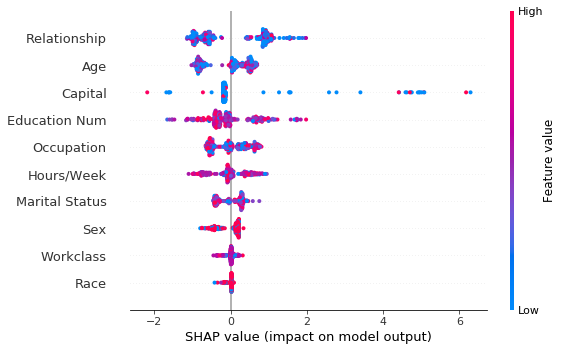

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_test.iloc[:300])
shap.summary_plot(shap_values, X_train.iloc[:300])

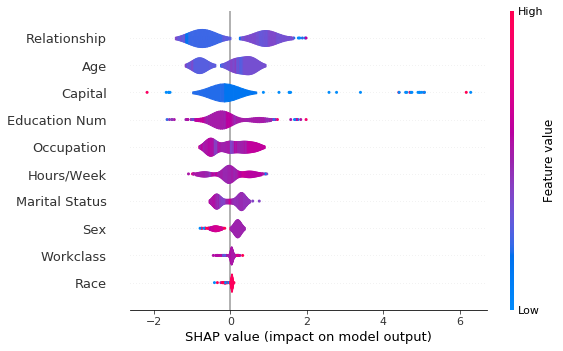

In [ ]:
shap.summary_plot(shap_values, X_train.iloc[:300], plot_type="violin")

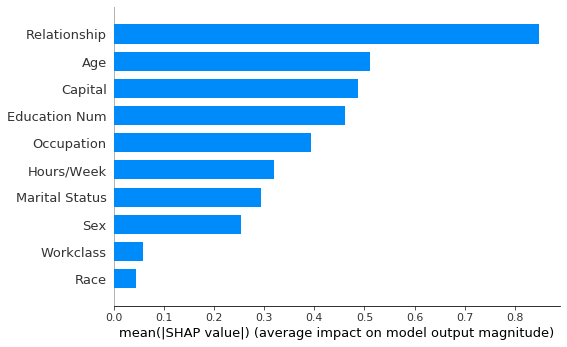

In [ ]:
shap.summary_plot(shap_values, X_train.iloc[:300], plot_type="bar")

In [ ]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [ ]:
print('Income 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

Income 예측에 대한 Positive 요인 Top 3 입니다:
1. Sex : 1.0
2. Workclass : 4.0
3. Hours/Week : 40.0


Negative 요인 Top 3 입니다:
1. Relationship : 3.0
2. Age : 1.0
3. Occupation : 6.0


## 5-Q1. 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
* Sex, Age, Occupation, Relationship, Education Num, Hours/Week, Workclass
## 5-Q2. 어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?
* Sex, Age, Occupation, Relationship, Education Num, Hours/Week, Workclass
* shap.summary_plot 이용하면 예측에 영향을 미치는 특성들을 볼 수 있다.